In [135]:
import pandas as pd
import numpy as np
import scipy.stats
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import bernoulli, binom
from scipy.stats import t
from sklearn.model_selection import train_test_split
from scipy.stats import kstest, uniform

import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
# Load data
df = pd.read_csv('homework3.csv')
df = df.rename(columns={'Unnamed: 0': 'uid'})
# Calculate the user-level CTR for each user
df['CTR'] = df['clicks'] / df['impressions']
df

,uid,clicks,impressions,CTR
0,1,0,63,0.000000
1,2,0,66,0.000000
2,3,0,35,0.000000
3,4,9,61,0.147541
4,5,0,47,0.000000
...,...,...,...,...
9987,9988,7,47,0.148936
9988,9989,8,78,0.102564
9989,9990,0,52,0.000000
9990,9991,7,71,0.098592


# Problem 1: Single Average CTR

## 1.1
In this case, instead of implementing the traditional approach, you can further approximate the click event using a Bernoulli distribution, then the total number of clicks follow a binomial distribution. Now you can calculate the variance of CTR using p(1-p)/N, where p is your CTR.

In [105]:
# Define your metric function
def single_average_ctr(clicks, impressions):
    return clicks / impressions

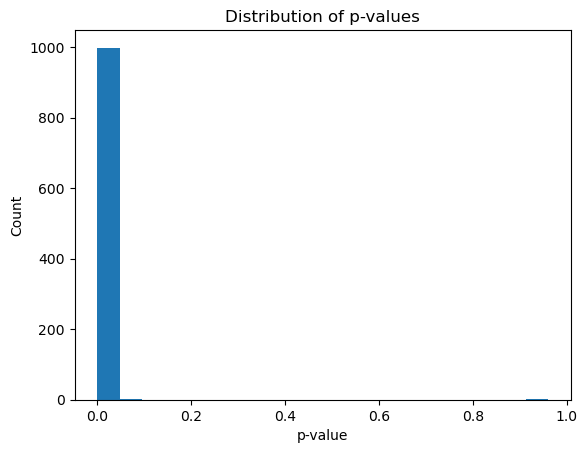

In [149]:
# Set up the simulation
n_simulations = 1000
p_values_1_1 = np.zeros(n_simulations)

for i in range(n_simulations):
    # Randomly spilt the data
    boot_sample = df.sample(frac=0.5)
    
    # Calculate the Single Average CTR for each group
    group1_clicks = boot_sample.iloc[:len(boot_sample)//2]['clicks'].sum()
    group1_impressions = boot_sample.iloc[:len(boot_sample)//2]['impressions'].sum()
    group1_ctr = single_average_ctr(group1_clicks, group1_impressions)
    
    group2_clicks = boot_sample.iloc[len(boot_sample)//2:]['clicks'].sum()
    group2_impressions = boot_sample.iloc[len(boot_sample)//2:]['impressions'].sum()
    group2_ctr = single_average_ctr(group2_clicks, group2_impressions)
    
    # Calculate the difference in CTR
    ctr_diff = group2_ctr - group1_ctr
    
    # Calculate the variance of CTR using the Bernoulli and binomial distribution
    n1 = group1_impressions
    n2 = group2_impressions
    p1 = group1_ctr
    p2 = group2_ctr
    var1 = p1*(1-p1)/n1
    var2 = p2*(1-p2)/n2
    var_diff = var1 + var2
    
    # Calculate the standard error and test statistic
    se = np.sqrt(var_diff)
    test_stat = ctr_diff / se * np.sqrt(n1+n2)
    
    # Calculate the p-value
    p_value = norm.sf(abs(test_stat)) * 2
    p_values_1_1[i] = p_value

# Plot the distribution of p-values
plt.hist(p_values_1_1, bins=20)
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Count')
plt.show()

In [150]:
# Report observations for 1.1
mean_p_value = np.mean(p_values_1_1)
significant_tests = sum(p_values_1_1 < 0.05)
print(f"Mean p-value: {mean_p_value:.3f}")
print(f"Number of significant tests: {significant_tests} out of {n_simulations}")

Mean p-value: 0.001
Number of significant tests: 998 out of 1000


## 1.2
Plot the distribution of p-value using variance estimation approach 2 and report what you observe.

In [117]:
#variance estimation of metrics ratio using delta method
def var_ratio(x,y): #x/y
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x,ddof=1)
    var_y = np.var(y,ddof=1)
    cov_xy = np.cov(x,y,ddof=1)[0][1]
    result = (var_x/mean_x**2 + var_y/mean_y**2 - 2*cov_xy/(mean_x*mean_y))*(mean_x*mean_x)/(mean_y*mean_y*len(x))
    return result 

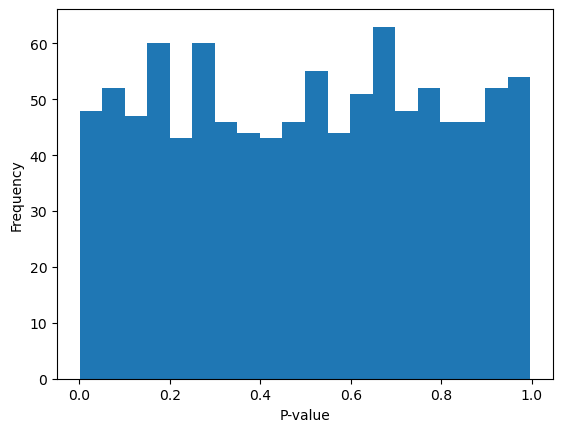

In [139]:
# Initialize an empty list to store the p-values
p_values_1_2 = np.zeros(1000)

# Repeat the simulation for 1000 times
for i in range(1000):
    # Randomly split the data into two groups
    group_control = df.sample(frac=0.5)
    group_treatment = df.drop(group_control.index)
    
    # Calculate CTR for each group
    ctr_control = group_control['clicks'].sum() / group_control['impressions'].sum()
    ctr_treatment = group_treatment['clicks'].sum() / group_treatment['impressions'].sum()
    
    # Calculate CTR variance for each group
    var_control = var_ratio(group_control['clicks'],group_control['impressions'])
    var_treatment = var_ratio(group_treatment['clicks'],group_treatment['impressions'])
    
    # Calculate observed difference in CTR
    diff = ctr_treatment - ctr_control 
    
    # Calculate the standard error
    se = np.sqrt(var_control+var_treatment)
    
    # Calculate the test statistic and p-value
    test_statistic = diff / se
    p_value = 2 * (1 - stats.norm.cdf(abs(test_statistic)))
    
    # Append the p-value to the list
    p_values_1_2[i] = p_value
    
# Plot the distribution of p-values
plt.hist(p_values_1_2, bins=20)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

In [140]:
# Report observations for 1.2
mean_p_value = np.mean(p_values_1_2)
significant_tests = sum(p_values_1_2 < 0.05)
print(f"Mean p-value: {mean_p_value:.3f}")
print(f"Number of significant tests: {significant_tests} out of {n_simulations}")

Mean p-value: 0.502
Number of significant tests: 48 out of 1000


## 1.3
Plot the distribution of p-value using variance estimation approach 3 and report what you observe

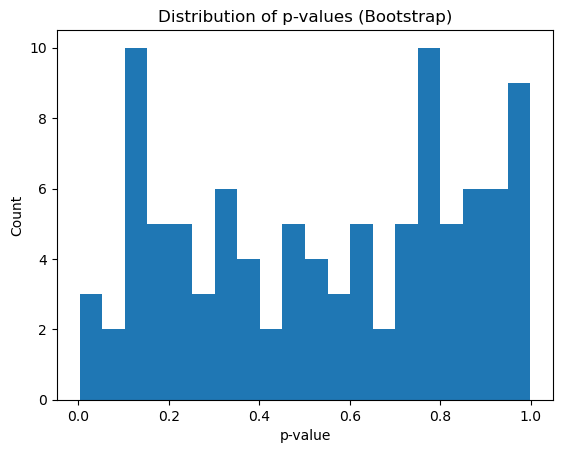

In [142]:
# Set up the bootstrap simulation
n_simulations = 100
n_bootstrap = 100
p_values_1_3 = np.zeros(n_simulations)

for i in range(n_simulations):
    # Sample with replacement from the data
    boot_sample = df.sample(n=len(df), replace=True)
    
    # Calculate the Single Average CTR for each group
    group1_clicks = boot_sample.iloc[:len(boot_sample)//2]['clicks'].sum()
    group1_impressions = boot_sample.iloc[:len(boot_sample)//2]['impressions'].sum()
    group1_ctr = group1_clicks / group1_impressions
    
    group2_clicks = boot_sample.iloc[len(boot_sample)//2:]['clicks'].sum()
    group2_impressions = boot_sample.iloc[len(boot_sample)//2:]['impressions'].sum()
    group2_ctr = group2_clicks / group2_impressions
    
    # Calculate the difference in CTR
    ctr_diff = group2_ctr - group1_ctr
    
    # Calculate the standard error using the bootstrap
    ctr_boot_samples = np.zeros(n_bootstrap)
    for j in range(n_bootstrap):
        boot_sample = boot_sample.sample(n=len(boot_sample), replace=True)
        group1_clicks = boot_sample.iloc[:len(boot_sample)//2]['clicks'].sum()
        group1_impressions = boot_sample.iloc[:len(boot_sample)//2]['impressions'].sum()
        group1_ctr = group1_clicks / group1_impressions
        group2_clicks = boot_sample.iloc[len(boot_sample)//2:]['clicks'].sum()
        group2_impressions = boot_sample.iloc[len(boot_sample)//2:]['impressions'].sum()
        group2_ctr = group2_clicks / group2_impressions
        ctr_boot_samples[j] = group2_ctr - group1_ctr
    se_boot = np.std(ctr_boot_samples)
    
    # Calculate the test statistic and p-value
    test_stat = ctr_diff / se_boot
    p_value = norm.sf(abs(test_stat)) * 2
    p_values_1_3[i] = p_value

# Plot the distribution of p-values
import matplotlib.pyplot as plt
plt.hist(p_values_1_3, bins=20)
plt.title('Distribution of p-values (Bootstrap)')
plt.xlabel('p-value')
plt.ylabel('Count')
plt.show()

In [143]:
# Report observations for 1.3
mean_p_value = np.mean(p_values_1_3)
significant_tests = sum(p_values_1_3 < 0.05)
print(f"Mean p-value: {mean_p_value:.3f}")
print(f"Number of significant tests: {significant_tests} out of {n_simulations}")

Mean p-value: 0.544
Number of significant tests: 3 out of 100


## 1.4

I run KS (Kolmogorov-Smirnov) test to test the p-value distribution against a uniform distribution.

### 1.1

In [151]:
# observed frequencies
observed_freq = p_values_1_1

# perform KS test to test uniformity
statistic, p_value = kstest(observed_freq, uniform().cdf)

# print results
print(f"KS test statistic: {statistic}")
print(f"p-value: {p_value}")

# gauge whether to reject null hypothesis
if p_value < 0.05:
    print("Reject null hypothesis (not uniform)")
else:
    print("Do not reject null hypothesis (uniform)")

KS test statistic: 0.9979322423325748
p-value: 0.0
Reject null hypothesis (not uniform)


### 1.2

In [141]:
# observed frequencies
observed_freq = p_values_1_2

# perform KS test to test uniformity
statistic, p_value = kstest(observed_freq, uniform().cdf)

# print results
print(f"KS test statistic: {statistic}")
print(f"p-value: {p_value}")

# gauge whether to reject null hypothesis
if p_value < 0.05:
    print("Reject null hypothesis (not uniform)")
else:
    print("Do not reject null hypothesis (uniform)")

KS test statistic: 0.016808709191310278
p-value: 0.9355525515070517
Do not reject null hypothesis (uniform)


### 1.3

In [144]:
# observed frequencies
observed_freq = p_values_1_3

# perform KS test to test uniformity
statistic, p_value = kstest(observed_freq, uniform().cdf)

# print results
print(f"KS test statistic: {statistic}")
print(f"p-value: {p_value}")

# gauge whether to reject null hypothesis
if p_value < 0.05:
    print("Reject null hypothesis (not uniform)")
else:
    print("Do not reject null hypothesis (uniform)")

KS test statistic: 0.12381539069602787
p-value: 0.0854796261130349
Do not reject null hypothesis (uniform)


### Conclusion

From above, approach 1 failed AA test, approach 2 and 3 passed AA test.

# Problem 2: Double Average CTR
calculate user level CTR first, and then take the average across all users

## 2.1

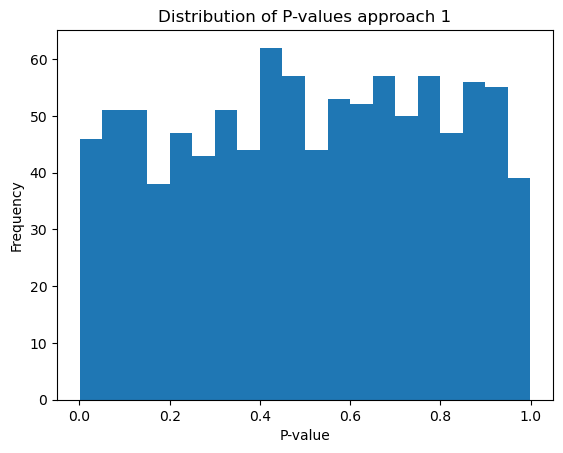

In [145]:
# Set up parameters for simulation
num_sims = 1000
significance_level = 0.05

# Initialize array to store p-values from each simulation
p_values_2_1 = np.zeros(num_sims)

# Loop over simulations
for i in range(num_sims):
    # Split data randomly into two groups
    group1, group2 = train_test_split(df["CTR"], test_size=0.5) 
    
    # Calculate sample variances for each group
    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=1)
    
    # Calculate pooled variance
    pool_var = (var1 + var2) / 2
    
    # Calculate t-statistic and p-value
    t_val = (group1.mean() - group2.mean()) / np.sqrt(pool_var * (1 / len(group1) + 1 / len(group2)))
    dfs = len(df) - 2
    p_val = scipy.stats.t.sf(abs(t_val), dfs) * 2
    
    # Store p-value
    p_values_2_1[i] = p_val

# Plot the histogram of p-values
plt.hist(p_values_2_1, bins=20)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of P-values approach 1')
plt.show()

In [146]:
# Report observations for 2.1
mean_p_value = np.mean(p_values_2_1)
significant_tests = sum(p_values_2_1 < 0.05)
print(f"Mean p-value: {mean_p_value:.3f}")
print(f"Number of significant tests: {significant_tests} out of {n_simulations}")

Mean p-value: 0.508
Number of significant tests: 46 out of 100


## 2.2

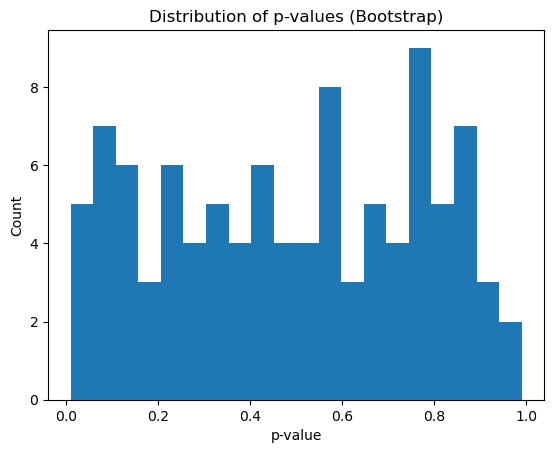

In [112]:
# Set up the bootstrap simulation
n_simulations = 100
n_bootstrap = 100
p_values = np.zeros(n_simulations)

for i in range(n_simulations):
    # Sample with replacement from the data
    boot_sample = df.sample(n=len(df), replace=True)
    
    # Calculate the Double Average CTR for each group
    group1_ctr = boot_sample.iloc[:len(boot_sample)//2].apply(lambda x: x['clicks']/x['impressions'], axis=1).mean()
    group2_ctr = boot_sample.iloc[len(boot_sample)//2:].apply(lambda x: x['clicks']/x['impressions'], axis=1).mean()
    
    # Calculate the difference in CTR
    ctr_diff = group2_ctr - group1_ctr
    
    # Calculate the standard error using the bootstrap
    ctr_boot_samples = np.zeros(n_bootstrap)
    for j in range(n_bootstrap):
        boot_sample = boot_sample.sample(n=len(boot_sample), replace=True)
        group1_ctr = boot_sample.iloc[:len(boot_sample)//2].apply(lambda x: x['clicks']/x['impressions'], axis=1).mean()
        group2_ctr = boot_sample.iloc[len(boot_sample)//2:].apply(lambda x: x['clicks']/x['impressions'], axis=1).mean()
        ctr_boot_samples[j] = group2_ctr - group1_ctr
    se_boot = np.std(ctr_boot_samples)
    
    # Calculate the test statistic and p-value
    test_stat = ctr_diff / se_boot
    p_value = norm.sf(abs(test_stat)) * 2
    p_values[i] = p_value

# Plot the distribution of p-values
plt.hist(p_values, bins=20)
plt.title('Distribution of p-values (Bootstrap)')
plt.xlabel('p-value')
plt.ylabel('Count')
plt.show()

In [113]:
# Report observations for 2.2
mean_p_value = np.mean(p_values)
significant_tests = sum(p_values < 0.05)
print(f"Mean p-value: {mean_p_value:.3f}")
print(f"Number of significant tests: {significant_tests} out of {n_simulations}")

Mean p-value: 0.487
Number of significant tests: 5 out of 100


## 2.3

### 2.1

In [147]:
# observed frequencies
observed_freq = p_values_2_1

# perform KS test to test uniformity
statistic, p_value = kstest(observed_freq, uniform().cdf)

# print results
print(f"KS test statistic: {statistic}")
print(f"p-value: {p_value}")

# gauge whether to reject null hypothesis
if p_value < 0.05:
    print("Reject null hypothesis (not uniform)")
else:
    print("Do not reject null hypothesis (uniform)")

KS test statistic: 0.02955895115456253
p-value: 0.3399507152319221
Do not reject null hypothesis (uniform)


### 2.2

In [148]:
# observed frequencies
observed_freq = p_values

# perform KS test to test uniformity
statistic, p_value = kstest(observed_freq, uniform().cdf)

# print results
print(f"KS test statistic: {statistic}")
print(f"p-value: {p_value}")

# gauge whether to reject null hypothesis
if p_value < 0.05:
    print("Reject null hypothesis (not uniform)")
else:
    print("Do not reject null hypothesis (uniform)")

KS test statistic: 0.030738092864961652
p-value: 0.29516427037430304
Do not reject null hypothesis (uniform)


### Conclusion

Apprpach 1 and 3 pass the AA test.

## 2.4

Single average CTR (Click-Through Rate) is calculated by taking the total number of clicks and dividing it by the total number of impressions. It is a simple and straightforward metric that measures the effectiveness of an ad campaign at a high level.

On the other hand, double average CTR is calculated by first calculating the CTR for each user and then taking the average across all users. This metric takes into account individual variations in user behavior and can provide more granular insights into the performance of an ad campaign.

The main difference between the two metrics is that single average CTR treats all users equally and assumes that they have the same behavior and preferences when interacting with the ads. Double average CTR, on the other hand, takes into account the fact that users may have different preferences and behavior when interacting with the ads and provides a more detailed view of campaign performance.

The main advantage of using a single average CTR is that it is a simple and straightforward metric that can provide an overall view of campaign performance. It is easy to understand and compare across different campaigns. However, it does not take into account individual differences in user behavior and may not be able to identify specific areas for improvement.

The main advantage of using double average CTR is that it takes into account individual variations in user behavior and provides more granular insights into campaign performance. It can help identify specific areas for improvement and provide insights into user behavior and preferences. However, it is a more complex metric that requires more data and analysis and may not be as easy to compare across different campaigns.